In [1]:
# Load Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
import sqlite3
import seaborn as sns
from matplotlib.pyplot import figure
from bs4 import BeautifulSoup
import time
import requests     # to get images
import shutil       # to save files locally
import datetime
from scipy.stats import norm
import warnings
warnings.filterwarnings('ignore')
from random import randint
import  random
import os
os.chdir('C:/Users/Travis/OneDrive/Data Science/Personal_Projects/Sports/UFC_Prediction_V2')
import winsound

from cmath import nan

sound_file = "data/audio/Jobs Done.wav"

def play_jobs_done():
    winsound.PlaySound(sound_file, winsound.SND_FILENAME)


bad_sound_file = 'data/audio/Danger Will Robinson.wav'

def play_danger():
    winsound.PlaySound(bad_sound_file, winsound.SND_FILENAME)

In [2]:
# Load fights df
fights_df = pd.read_csv('data/final/aggregates/Fight_DF.csv')
print(fights_df.shape)
fights_df.head()

(8411, 78)


,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,4,4,1.000000,1.000000,13,28,0,0,0.464286,0.000000
1,Joshua Burkman,Josh Neer,1,0,35,88,19,39,0.39,0.48,...,5,9,0.571429,0.555556,5,10,7,9,0.500000,0.777778
2,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,2,2,0.000000,1.000000,1,1,3,3,1.000000,1.000000
3,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0,1,1.000000,0.000000,0,0,0,0,0.000000,0.000000
4,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,3,8,0.750000,0.375000,10,17,0,0,0.588235,0.000000


### Add Fighter Odds

Makes sense to do it before doubling the dataframe

In [3]:
# Load Fighter Odds
odds_by_fighter = pd.read_csv('data/final/odds/All_Odds_by_Fighter_WithChange.csv')

print(f' df shape: {odds_by_fighter.shape}')
odds_by_fighter.head()

 df shape: (24396, 8)


,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0
2,Georges St-Pierre,-275.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,NaN
3,Thiago Alves,250.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-6.0
4,Dan Henderson,-200.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,4.0


In [4]:
# Split the 'event_ufcstats_url' column by '/' and get the last element from the resulting list, 
# then set it as a new column named 'event_code'
odds_by_fighter['event_code'] = odds_by_fighter['event_ufcstats_url'].str.split('/').str[-1] 

# Remove leading and trailing whitespace from the 'fighter' column
odds_by_fighter['fighter'] = odds_by_fighter['fighter'].str.strip()

# Show the first three rows of the resulting DataFrame
odds_by_fighter.head(3)

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0,0ee783aa00e468f0
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0,0ee783aa00e468f0
2,Georges St-Pierre,-275.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,NaN,0ee783aa00e468f0


In [5]:
event_data = pd.read_csv('data/final/events/All_Events_Fights_and_FightUrls.csv')

In [6]:
# Remove whitespace from left and right of the values in the column 'Fighter1'
event_data['Fighter1'] = event_data['Fighter1'].str.strip()

# Remove whitespace from left and right of the values in the column 'Fighter2'
event_data['Fighter2'] = event_data['Fighter2'].str.strip()

# Print the first 3 rows of the DataFrame to verify changes made
event_data.head(3)

,Unnamed: 0.1,Unnamed: 0,W/L,Weight class,Method,Round,Time,Fighter1,Fighter2,F1_Kd,F2_Kd,F1_Str,F2_Str,F1_Td,F2_Td,F1_Sub,F2_Sub,fight_num,event_id,fight_link
0,0,0,win,Heavyweight,KO/TKO Punches,3,4:23,Ciryl Gane,Tai Tuivasa,1,1,110,29,0,0,0,0,1,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/810c9da0...
1,1,1,win,Middleweight,U-DEC,3,5:00,Robert Whittaker,Marvin Vettori,0,0,74,33,1,0,0,0,2,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/b8ca1acd...
2,2,2,win,Middleweight,U-DEC,3,5:00,Nassourdine Imavov,Joaquin Buckley,0,0,51,46,2,0,2,0,3,00a905a4a4a2b071,http://www.ufcstats.com/fight-details/20f316f9...


In [7]:
# Make sure the formatting is the same

event_data['event_id'] = event_data['event_id'].astype(str)
odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)

In [8]:
# pick random row from odds_by_fighter
rand_row = odds_by_fighter.sample(1)
rand_row

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code
15233,Holloway points handicap -3½,-250.0,NaN,https://www.bestfightodds.com/events/ufc-fight...,http://ufcstats.com/event-details/f9c7fe2682af...,ufc-fight-night-60-henderson-vs-thatch-915,UFC Fight Night: Henderson vs Thatch,NaN,f9c7fe2682af3802


In [9]:
# Filter the event_data DataFrame where the 'event_id' column matches the value of the first element in the 'rand_row' DataFrame's 'event_code' column
test_data = event_data[event_data['event_id'] == rand_row['event_code'].values[0]]

# Print the resulting DataFrame
print(test_data)

      Unnamed: 0.1  Unnamed: 0  W/L   Weight class                 Method  \
5647          5647           0  win   Welterweight  SUB  Rear Naked Choke   
5648          5648           1  win  Featherweight                  U-DEC   
5649          5649           2  win   Welterweight  SUB  Rear Naked Choke   
5650          5650           3  win   Middleweight                  U-DEC   
5651          5651           4  win    Lightweight                  U-DEC   
5652          5652           5  win      Flyweight            SUB  Kimura   
5653          5653           6  win    Lightweight                  U-DEC   
5654          5654           7  win  Featherweight        KO/TKO  Punches   
5655          5655           8  win      Flyweight                  U-DEC   
5656          5656           9  win    Lightweight  SUB  Rear Naked Choke   

      Round  Time          Fighter1         Fighter2  F1_Kd  F2_Kd  F1_Str  \
5647      4  3:58  Benson Henderson   Brandon Thatch      0      0      57

In [10]:
def grab_fight_url(fighter, event_code):
        try:
                data = event_data[event_data['event_id'] == event_code]
                data1 = data[data['Fighter1'] == fighter]
                data2 = data[data['Fighter2'] == fighter]
                data3 = pd.concat([data1, data2])

                return data3['fight_link'].values[0]
        except:
                return np.nan

In [11]:
# test
grab_fight_url('Robert Whittaker', '00a905a4a4a2b071')

'http://www.ufcstats.com/fight-details/b8ca1acdf3dc2f58'

In [12]:
# add fight urls to odds by fighter
odds_by_fighter['fight_url'] = odds_by_fighter.apply(lambda row: grab_fight_url(row['fighter'], row['event_code']), axis=1)

In [13]:
odds_by_fighter.head(2)

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code,fight_url
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...


In [14]:
# add columns 'odds' to odds by fighter, where odds is equal to the 5D column unless it is nan, then it is equal to the Ref column
odds_by_fighter['odds'] = odds_by_fighter.apply(lambda row: row['5D'] if np.isnan(row['5D']) == False else row['Ref'], axis=1)

In [15]:
odds_by_fighter.head(2)

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code,fight_url,odds
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...,-225.0
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...,205.0


In [16]:
# save odds by fighter with fight urls
odds_by_fighter.to_csv('data/final/odds/All_Odds_by_Fighter_With_Fight_Urls.csv', index=False)

### Double the Fights_DF

To ensure that we are measuring both fighters equally, I double the dataframe to create a version of each fight where the A fighter and B Fighter are switched, along with all of their data.

In [17]:
# Create the double fights df (switching A and B)
fights_df2 = fights_df.copy()

# switch all _A and A_ to _C and C_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_A', 'Fighter_C')
fights_df2.columns = fights_df2.columns.str.replace('A_', 'C_')

# switch all _B and B_ to _A and A_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_B', 'Fighter_A')
fights_df2.columns = fights_df2.columns.str.replace('B_', 'A_')

# switch all _C and C_ to _B and B_
fights_df2.columns = fights_df2.columns.str.replace('Fighter_C', 'Fighter_B')
fights_df2.columns = fights_df2.columns.str.replace('C_', 'B_')

fights_df2.head()

,Fighter_B,Fighter_A,B_Kd,A_Kd,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_percent,A_Sig_strike_percent,...,A_Clinch_Strikes_land,A_Clinch_Strikes_att,B_Clinch_Strikes_percent,A_Clinch_Strikes_percent,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_percent,A_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,4,4,1.000000,1.000000,13,28,0,0,0.464286,0.000000
1,Joshua Burkman,Josh Neer,1,0,35,88,19,39,0.39,0.48,...,5,9,0.571429,0.555556,5,10,7,9,0.500000,0.777778
2,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,2,2,0.000000,1.000000,1,1,3,3,1.000000,1.000000
3,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0,1,1.000000,0.000000,0,0,0,0,0.000000,0.000000
4,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,3,8,0.750000,0.375000,10,17,0,0,0.588235,0.000000


In [18]:
# add the new columns to the original df
double_fights_df = pd.concat([fights_df, fights_df2], axis=0)
double_fights_df.head(3)

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,4,4,1.000000,1.000000,13,28,0,0,0.464286,0.000000
1,Joshua Burkman,Josh Neer,1,0,35,88,19,39,0.39,0.48,...,5,9,0.571429,0.555556,5,10,7,9,0.500000,0.777778
2,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,2,2,0.000000,1.000000,1,1,3,3,1.000000,1.000000


In [19]:
double_fights_df.to_csv('data/final/aggregates/Fight_DF_V2.csv', index=False)

In [20]:
double_fights_df.head(3)

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_land,B_Clinch_Strikes_att,A_Clinch_Strikes_percent,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,4,4,1.000000,1.000000,13,28,0,0,0.464286,0.000000
1,Joshua Burkman,Josh Neer,1,0,35,88,19,39,0.39,0.48,...,5,9,0.571429,0.555556,5,10,7,9,0.500000,0.777778
2,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,2,2,0.000000,1.000000,1,1,3,3,1.000000,1.000000


## Add Odds by Fighter to FightsDf

### Load Point for OddsByFighter

In [21]:
# load
odds_by_fighter = pd.read_csv('data/final/odds/All_Odds_by_Fighter_With_Fight_Urls.csv')

#### Note: We want to use ufcstats Urls as our connector

We could also just use the event code if that isnt working for some reason

In [22]:
odds_by_fighter.head(2)

,fighter,5D,Ref,event_odds_url,event_ufcstats_url,event_id,event_name,odds_change,event_code,fight_url,odds
0,Brock Lesnar,-225.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,-31.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...,-225.0
1,Frank Mir,205.0,NaN,https://www.bestfightodds.com/events/ufc-100-137,http://ufcstats.com/event-details/0ee783aa00e4...,ufc-100-137,UFC 100,59.0,0ee783aa00e468f0,http://www.ufcstats.com/fight-details/8df2751d...,205.0


In [23]:
# make sure formatting is the same (string)
odds_by_fighter['event_ufcstats_url'] = odds_by_fighter['event_ufcstats_url'].astype(str)
odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)
double_fights_df['event_url'] = double_fights_df['event_url'].astype(str)

# make sure name formatting is same
odds_by_fighter['fighter'] = odds_by_fighter['fighter'].str.strip()
double_fights_df['Fighter_A'] = double_fights_df['Fighter_A'].str.strip()
double_fights_df['Fighter_B'] = double_fights_df['Fighter_B'].str.strip()

In [24]:
# Add column "Event Code", which is event code for ufcstats
double_fights_df['event_code'] = double_fights_df['event_url'].str.split('/').str[-1]
double_fights_df['event_code'] = double_fights_df['event_code'].astype(str)

In [25]:
# check the differences between double_fights_df['event_code'] and odds_by_fighter['event_code']
dfights = double_fights_df['event_code'].unique()
odds = odds_by_fighter['event_code'].unique()

# check differences in list
diff = [x for x in dfights if x not in odds]
diff

['f70144caea5c4c80',
 '9ca265dfe8323db3',
 '0e9869d712e81f8f',
 'b4eeac608fc82f88',
 'd56caaa5e123f518',
 'e0b74df14f52cd15',
 '2299605af59fd309',
 '2f3f12002564bb55',
 '60029bcf496bd707',
 'a6a9ab5a824e8f66',
 '234f3767ff0e5701',
 'ae58685caf8e4a0d',
 '6420efac0578988b',
 '8738eacd62e82a32',
 '318e629d1eb7aa49',
 '365fee2da473b177',
 'b19fc66613dc75b9',
 '440c9dbab63528fb',
 'a5b0bd216d8ba84e',
 '1a225f04aa6e0739',
 'c3ea8deeba00462b',
 'cf9d24e4bd0cf2ce',
 'dd8aec6de7035943',
 '179f1948dc234f1f',
 'bd4389b71fdc0ce2',
 'e4bb7e483c4ad318',
 '08ae5cd9aef7ddd3',
 'f9f07bb5a43535ed',
 'e4bde462b043d3e1',
 '80c0bed43da0e27b',
 '672ef06fd9f41f7d',
 'c933d423ebdbbbdb',
 '0e041d43a47d2e4b',
 '79ded75550efc139',
 '265589bdd93e7ce5',
 'be9d259be012e8a4',
 '7ca4c3f8aa8bacae',
 'c32fdfe75cda5b22',
 '1ffc38f67785797b',
 'a71feb7ea7592a71',
 'bc3876891e155bb5',
 '4908c5ee68a50ee5',
 'e8fb8e53bc2e29d6',
 '492b202d2064e7a9',
 'baa5358456803df8',
 'a220be6d41d6f97d',
 '75f871836d41f90f',
 '7c0847d3854

In [26]:
diff2 = [x for x in odds if x not in dfights]
diff2

['885e7f70dcac0007',
 '01dd4cdc2446f665',
 '49c29e57d4e2be6f',
 'be5aab761c40ef35',
 '756f45905fb20cb5',
 'f21a3d68fb9df387',
 'aec273fcb765330d',
 'd26394fc0e8e880a',
 '4f670b7972fa0a2e']

### Note: The double fights DF has lots of OUTSIDE of UFC fights, whereas the odds does not. As we want to focus on the UFC events, this is okay. 

In [27]:
# Check Dtypes of odds_by_fighter
odds_by_fighter.dtypes

fighter                object
5D                    float64
Ref                   float64
event_odds_url         object
event_ufcstats_url     object
event_id               object
event_name             object
odds_change           float64
event_code             object
fight_url              object
odds                  float64
dtype: object

In [28]:
odds_by_fighter['event_code'] = odds_by_fighter['event_code'].astype(str)
odds_by_fighter['event_ufcstats_url'] = odds_by_fighter['event_ufcstats_url'].astype(str)

In [29]:
# This function takes in an event code and fighter name as parameters
def get_odds_from_obf(event_code, fighter):
    try:
        # Selects data from odds_by_fighter that has the event_code equal to the provided event_code
        data = odds_by_fighter[odds_by_fighter['event_code'] == event_code]
        # Filters the above data further by only returning data with the fighter name equal to the provided fighter name
        data = data[data['fighter'] == fighter]
        # Returns the odds value for the fighter in the provided event.
        return data['odds'].values[0]
    except:
        # If any error occurs during the processing above, return NaN
        return np.nan

In [30]:
# test
get_odds_from_obf('805ad1801eb26abb', 'Holly Holm')

-125.0

In [31]:
double_fights_df['Fighter_A_Odds'] = double_fights_df.apply(lambda row: get_odds_from_obf(row['event_code'], row['Fighter_A']), axis=1)
double_fights_df['Fighter_B_Odds'] = double_fights_df.apply(lambda row: get_odds_from_obf(row['event_code'], row['Fighter_B']), axis=1)

In [32]:
# check missing
double_fights_df[double_fights_df['Fighter_A_Odds'].isna()]

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent,event_code,Fighter_A_Odds,Fighter_B_Odds
1,Joshua Burkman,Josh Neer,1,0,35,88,19,39,0.39,0.48,...,0.555556,5,10,7,9,0.500000,0.777778,f70144caea5c4c80,NaN,NaN
6,Tony Ferguson,Katsunori Kikuno,1,0,38,67,22,44,0.56,0.50,...,0.000000,0,0,0,0,0.000000,0.000000,9ca265dfe8323db3,NaN,NaN
7,Rich Franklin,David Loiseau,2,1,127,244,21,72,0.52,0.29,...,0.444444,21,26,0,0,0.807692,0.000000,0e9869d712e81f8f,NaN,NaN
9,Caio Borralho,Jesse Murray,1,0,13,23,4,14,0.56,0.28,...,0.000000,8,12,0,0,0.666667,0.000000,b4eeac608fc82f88,NaN,NaN
13,Rameau Thierry,Sokoudjou Kazuhiro,1,0,26,46,6,23,0.56,0.26,...,0.000000,2,2,0,0,1.000000,0.000000,2549d63da9c456cb,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,Ken Shamrock,Royce Gracie,0,0,0,0,0,0,0.00,0.00,...,0.000000,0,0,0,0,0.000000,0.000000,6420efac0578988b,NaN,NaN
8405,Daiju Takase,Rodrigo Gracie,0,0,10,27,39,65,0.37,0.60,...,0.650000,3,3,23,37,1.000000,0.621622,cb46dface0e28a2c,NaN,NaN
8406,Wesley Correira,Tim Sylvia,0,0,26,65,138,214,0.40,0.64,...,0.796610,0,0,0,0,0.000000,0.000000,0cf935519d439ba6,NaN,NaN
8407,David Abbott,Kimo Leopoldo,0,0,0,0,1,1,0.00,1.00,...,0.000000,0,0,0,0,0.000000,0.000000,108afe61a26bcbf4,NaN,NaN


In [33]:
# check not missing
double_fights_df[double_fights_df['Fighter_A_Odds'].notna()]

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,B_Clinch_Strikes_percent,A_Ground_Strikes_land,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent,event_code,Fighter_A_Odds,Fighter_B_Odds
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,1.000000,13,28,0,0,0.464286,0.000000,805ad1801eb26abb,-125.0,105.0
2,Paddy Pimblett,Kazula Vargas,0,0,3,6,7,9,0.50,0.77,...,1.000000,1,1,3,3,1.000000,1.000000,1d00756835ca67c9,-600.0,NaN
3,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0.000000,0,0,0,0,0.000000,0.000000,3ae10ac4df3df05c,-400.0,325.0
4,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,0.375000,10,17,0,0,0.588235,0.000000,f54200f1dfb9b5d4,-310.0,280.0
5,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,0.40,...,0.000000,14,20,0,0,0.700000,0.000000,d4a12dfa4067742f,-200.0,185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8401,Francis Carmont,Jacare Souza,0,0,19,71,16,47,0.26,0.34,...,1.000000,0,0,6,9,0.000000,0.666667,51b0bb73a1da34bc,435.0,NaN
8403,Lucas Martins,Darren Elkins,0,0,26,82,47,154,0.31,0.30,...,0.480769,0,0,1,2,0.000000,0.500000,53f02bbc41d99432,200.0,-220.0
8404,Krzysztof Jotko,Sean Strickland,0,0,37,196,84,182,0.18,0.46,...,0.000000,0,0,0,0,0.000000,0.000000,d57e6a8971b6d2bd,205.0,-245.0
8408,Gleison Tibau,Tony Ferguson,0,0,2,20,11,38,0.10,0.28,...,0.000000,0,0,3,8,0.000000,0.375000,ad4e9055bf8cd04d,220.0,-240.0


## Add Odds Change to FightsDf

In [34]:
def get_odds_change_from_obf(event_code, fighter):
        try:
                # First, we filter the odds_by_fighter DataFrame by event code
                data = odds_by_fighter[odds_by_fighter['event_code'] == event_code]
                # Then, we filter by the designated fighter
                data = data[data['fighter'] == fighter]

                # We return the odds change value for that fighter and event code
                return data['odds_change'].values[0]
        except:
                return np.nan

In [35]:
# add odds change
double_fights_df['Fighter_A_Odds_Change'] = double_fights_df.apply(lambda row: get_odds_change_from_obf(row['event_code'], row['Fighter_A']), axis=1)
double_fights_df['Fighter_B_Odds_Change'] = double_fights_df.apply(lambda row: get_odds_change_from_obf(row['event_code'], row['Fighter_B']), axis=1)


In [36]:
double_fights_df.head(2)

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent,event_code,Fighter_A_Odds,Fighter_B_Odds,Fighter_A_Odds_Change,Fighter_B_Odds_Change
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,28,0,0,0.464286,0.000000,805ad1801eb26abb,-125.0,105.0,39.0,49.0
1,Joshua Burkman,Josh Neer,1,0,35,88,19,39,0.39,0.48,...,10,7,9,0.500000,0.777778,f70144caea5c4c80,NaN,NaN,NaN,NaN


<Axes: xlabel='Count', ylabel='variable'>

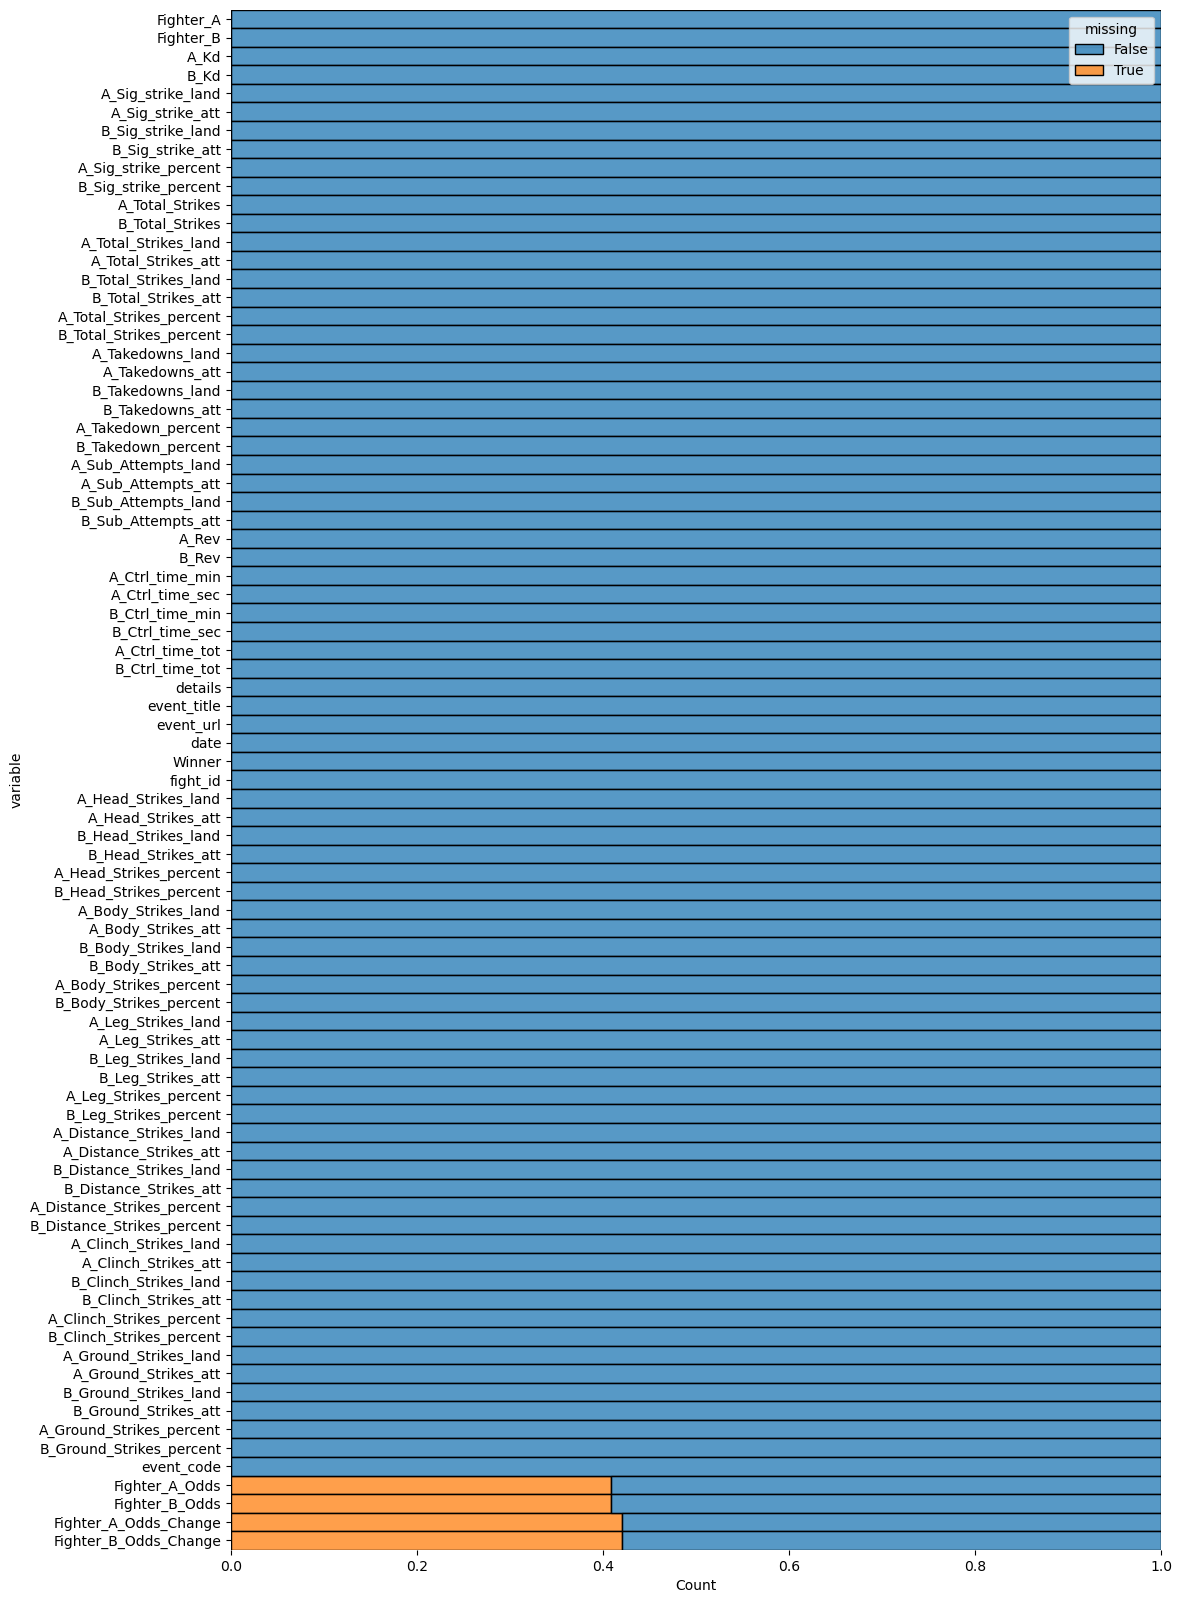

In [37]:
f, ax = plt.subplots(figsize = (12,20))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = double_fights_df.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

### As we know from earlier, we do not have many of these odds because these events were outside of the UFC. Thus, we can drop them. 

In [38]:
double_fights_df = double_fights_df.dropna()
double_fights_df.shape

(8824, 83)

In [39]:
double_fights_df.to_csv('data/final/aggregates/Double_Fights_DF_V1.csv', index=False)

In [40]:
double_fights_df= pd.read_csv('data/final/aggregates/Double_Fights_DF_V1.csv')

In [41]:
double_fights_df.head(3)

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,A_Ground_Strikes_att,B_Ground_Strikes_land,B_Ground_Strikes_att,A_Ground_Strikes_percent,B_Ground_Strikes_percent,event_code,Fighter_A_Odds,Fighter_B_Odds,Fighter_A_Odds_Change,Fighter_B_Odds_Change
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,28,0,0,0.464286,0.0,805ad1801eb26abb,-125.0,105.0,39.0,49.0
1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,0,0,0,0.000000,0.0,3ae10ac4df3df05c,-400.0,325.0,-16.0,-19.0
2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,17,0,0,0.588235,0.0,f54200f1dfb9b5d4,-310.0,280.0,23.0,-5.0


In [42]:
# find all objects in df
double_fights_df.select_dtypes(include=['object']).columns

Index(['Fighter_A', 'Fighter_B', 'A_Total_Strikes', 'B_Total_Strikes',
       'details', 'event_title', 'event_url', 'date', 'Winner', 'fight_id',
       'event_code'],
      dtype='object')

In [43]:
# drop A_Total_Strikes and B_Total_Strikes, they were not meant to be here. 
double_fights_df = double_fights_df.drop(['A_Total_Strikes', 'B_Total_Strikes'], axis=1)


## Add Feature: In-Fight Statistic Differentials

This is 

In [44]:
# calculate differences between in-match stats

for col in double_fights_df.columns:
    if col.startswith('A_'):
        new_col = col.replace('A_', 'Dif_')
        double_fights_df[new_col] = double_fights_df[col] - double_fights_df[col.replace('A_', 'B_')]
    else:
        continue

double_fights_df

,Fighter_A,Fighter_B,A_Kd,B_Kd,A_Sig_strike_land,A_Sig_strike_att,B_Sig_strike_land,B_Sig_strike_att,A_Sig_strike_percent,B_Sig_strike_percent,...,Dif_Leg_Strikes_percent,Dif_Distance_Strikes_land,Dif_Distance_Strikes_att,Dif_Distance_Strikes_percent,Dif_Clinch_Strikes_land,Dif_Clinch_Strikes_att,Dif_Clinch_Strikes_percent,Dif_Ground_Strikes_land,Dif_Ground_Strikes_att,Dif_Ground_Strikes_percent
0,Holly Holm,Irene Aldana,0,0,154,301,69,185,0.51,0.37,...,0.191033,75,91,0.155590,-3,-3,0.000000,13,28,0.464286
1,Greg Hardy,Ben Sosoli,0,0,54,105,26,97,0.51,0.26,...,-0.035714,26,7,0.234021,2,1,1.000000,0,0,0.000000
2,Jared Rosholt,Josh Copeland,0,0,22,45,9,36,0.48,0.25,...,0.000000,3,-4,0.160714,0,-4,0.375000,10,17,0.588235
3,Alistair Overeem,Stefan Struve,0,0,17,25,2,5,0.68,0.40,...,0.000000,-2,-2,-0.500000,3,2,1.000000,14,20,0.700000
4,Nordine Taleb,Kyle Prepolec,0,0,90,201,52,153,0.44,0.33,...,0.537838,38,48,0.109488,-1,-2,-0.500000,1,2,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8819,Marcus Davis,Mike Swick,0,0,31,55,32,86,0.56,0.37,...,-0.200000,7,12,0.108225,5,-3,0.373529,-13,-40,0.422222
8820,Lucas Martins,Darren Elkins,0,0,26,82,47,154,0.31,0.30,...,-0.200000,-2,-29,0.057606,-18,-41,0.155594,-1,-2,-0.500000
8821,Krzysztof Jotko,Sean Strickland,0,0,37,196,84,182,0.18,0.46,...,0.300000,-47,14,-0.272763,0,0,0.000000,0,0,0.000000
8822,Gleison Tibau,Tony Ferguson,0,0,2,20,11,38,0.10,0.28,...,-0.750000,-6,-10,-0.166667,0,0,0.000000,-3,-8,-0.375000


In [45]:
# add difference in odds
double_fights_df['Dif_Odds'] = double_fights_df['Fighter_A_Odds'] - double_fights_df['Fighter_B_Odds']

#### Add Distribution Stat Features

now fights = double_fights_df, for ease

In [46]:
fights = double_fights_df

In [47]:
def get_fighter_running_dist_stats(fighter, date, col_to_get, stat_to_calc):

    # retrieve data for all fights involving the given fighter
    data = fights[(fights['Fighter_A'] == fighter) | (fights['Fighter_B'] == fighter)]

    # convert date strings to datetime objects
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])

    # filter data to only include fights before the given date
    data = data[data['date'] < datey]

    # create an empty dataframe to store fighter data
    fighter_data = pd.DataFrame()

    # retrieve data for fights where the given fighter is Fighter A
    fighterA_df = fights[fights['Fighter_A'] == fighter]
    # retrieve data for fights where the given fighter is Fighter B
    fighterB_df = fights[fights['Fighter_B'] == fighter]

    # select relevant columns from Fighter A data and rename columns for consistency
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)

    # select relevant columns from Fighter B data and rename columns for consistency
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)

    # append Fighter A and Fighter B data to the fighter_data dataframe
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get the chosen statistic based on the input parameter
    if stat_to_calc == 'mean':
        x = fighter_data[col_to_get].mean()
    elif stat_to_calc == 'std':
        x = fighter_data[col_to_get].std()
    elif stat_to_calc == 'median':
        x = fighter_data[col_to_get].median()  

    # return the chosen statistic
    return x

#### Get Non-specific column names for Feature Creation

In [48]:
# This code creates three lists of column names from a dataframe called 'fights'
# The first list contains column names with 'Dif_' in them
# The second list contains column names that start with 'A_'
# The third list combines the second and first list

dif_cols = [n for n in fights.columns if 'Dif_' in n]
A_cols = [n for n in fights.columns if n.startswith('A_')]
all_metric_cols = A_cols + dif_cols

# This code creates a new dataframe containing the second list of column names without the 'A_' prefix
# It then creates a list of unique column name suffixes

A_cols2 = pd.DataFrame(A_cols)
A_cols2['nonspecific'] = A_cols2[0].str[2:]
the_cols = list(A_cols2['nonspecific'].unique())

In [49]:
# test get_fighter_running_dist_stats
get_fighter_running_dist_stats('Khabib Nurmagomedov', '2020-01-18', 'Sig_strike_land', 'mean')

55.75

These are split because they were causing problems when running all at once

In [50]:
# Mean First

for col in the_cols:
        fights['A_Rolling_' + col + '_' + 'mean'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'mean'), axis=1)

In [ ]:
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'mean'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'mean'), axis=1)

In [ ]:
# Now Median
for col in the_cols:
        fights['A_Rolling_' + col + '_' + 'median'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'median'), axis=1)

In [ ]:
# fighter 2 Median
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'median'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'median'), axis=1)

In [ ]:
# Now Std
for col in the_cols:
    fights['A_Rolling_' + col + '_' + 'std'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_A'], row['date'], col, 'std'), axis=1)


In [ ]:
# fighter 2 Std
for col in the_cols:
    fights['B_Rolling_' + col + '_' + 'std'] = fights.apply(lambda row: get_fighter_running_dist_stats(row['Fighter_B'], row['date'], col, 'std'), axis=1)

New Version:

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V2.csv', index=False)

In [ ]:
# Load point for fights df
#fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V2.csv')

### Feature: Top-Down Averages (typical UFC Style)

In [ ]:
def get_top_down_averages(fighter, date, col_to_get, dataframe):

    # for each column in all_metric_cols, calculate the top-down averages, as opposed to bottom-up
    data = dataframe[(dataframe['Fighter_A'] == fighter) | (dataframe['Fighter_B'] == fighter)]

    # only get fights before the date
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]

    # fighter could be either fighter A or fighter B
    fighter_data = pd.DataFrame()


    # fighterA df
    fighterA_df = dataframe[dataframe['Fighter_A'] == fighter]
    fighterB_df = dataframe[dataframe['Fighter_B'] == fighter]
    
    # keep only the fighters columns date, FighterA, and the col_to_get, 
    # do same for B, change col names from B to A, and concat
    fighterA_df = fighterA_df[['date', 'Fighter_A', 'A_' + col_to_get]]
    fighterA_df.rename(columns={'A_' + col_to_get: col_to_get, 'Fighter_A': 'fighter'}, inplace=True)
    fighterB_df = fighterB_df[['date', 'Fighter_B', 'B_' + col_to_get]]
    fighterB_df.rename(columns={'B_' + col_to_get: col_to_get, 'Fighter_B': 'fighter'}, inplace=True)
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # append the dataframes on fighter
    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get the average
    tot = fighter_data[col_to_get].sum()
    num = fighter_data[col_to_get].count()
    x = tot / num
    return x

In [ ]:
# delete rolling cols from the_cols
the_cols = [n for n in the_cols if 'Rolling' not in n]
the_cols

In [ ]:
# NEW -- fix, make this more modular

for col in the_cols:
    fights['A_topdown_Avg_' + col ] = fights.apply(lambda row: get_top_down_averages(row['Fighter_A'], row['date'], col, fights), axis=1)

In [ ]:
for col in the_cols:
    fights['B_topdown_Avg_' + col ] = fights.apply(lambda row: get_top_down_averages(row['Fighter_B'], row['date'], col, fights), axis=1)

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V3.csv')

In [ ]:
#fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V3.csv')

### Add Opponent Stats

In [ ]:
def get_opponent_averages(datafrm, date, col_to_get, fighter):
    col_to_get = 'B_' + col_to_get
    data = datafrm[(datafrm['Fighter_A'] == fighter) | (datafrm['Fighter_B'] == fighter)]
    datey = pd.to_datetime(date)
    data['date'] = pd.to_datetime(data['date'])
    data = data[data['date'] < datey]

    fighter_data = pd.DataFrame()

    fighterA_df = datafrm[datafrm['Fighter_A'] == fighter]
    fighterB_df = datafrm[datafrm['Fighter_B'] == fighter]

    # switch A_ and B_ to B_ and A_ in fighterB_df
    fighterB_df.columns = [n.replace('A_', 'C_') if n.startswith('A_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('B_', 'D_') if n.startswith('B_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('C_', 'B_') if n.startswith('C_') else n for n in fighterB_df.columns]
    fighterB_df.columns = [n.replace('D_', 'A_') if n.startswith('D_') else n for n in fighterB_df.columns]

    # copy fighter_A and fighter_B columns to new dataframe, then switch fighter_A and fighter_B columns

    fighterB_df.rename(columns={'Fighter_A': 'Fighter_A2', 'Fighter_B': 'Fighter_B2'}, inplace=True)
    fighterB_df.rename(columns={'Fighter_B2': 'Fighter_A', 'Fighter_A2': 'Fighter_B'}, inplace=True)

    fighter_data = fighter_data.append(fighterA_df)
    fighter_data = fighter_data.append(fighterB_df)

    # get sum of col to get
    col_sum = fighter_data[col_to_get].sum()
    # get number of fights
    num_fights = len(fighter_data)
    # get average
    avg = col_sum / num_fights

    return avg


In [ ]:
# test
get_opponent_averages(fights, '2017-01-01', 'Sig_strike_land', 'Conor McGregor')

In [ ]:
cols = [n for n in fights.columns if n.startswith('B_')]
cols = [n for n in cols if 'topdown_' not in n]
cols = [n for n in cols if 'Rolling_' not in n]
cols = [n for n in cols if 'Dif_' not in n]

In [ ]:
# delete the first 2 characters of each in col
cols2 = pd.DataFrame(cols)
cols2['nonspecific'] = cols2[0].str[2:]
cols2

# get unique values
the_cols = list(cols2['nonspecific'].unique())
the_cols

In [ ]:
n=0
# save as we go to intermediate_data, so we don't have to start over if we get an error

# check to see which columns have already been done
done_cols = [n for n in os.listdir('data/intermediate_data/') if n.startswith('Opponent_Averages_')]
done_cols = [n.replace('Opponent_Averages_', '') for n in done_cols]
done_cols = [n.replace('_.csv', '') for n in done_cols]
# remove the done columns from the_cols
the_cols = [n for n in the_cols if n not in done_cols]
print('Cols Remaining:' + str(len(the_cols)))

# loop through the remaining columns
for col in the_cols:
    try:
        fights['A_Opp_Avg_' + col] = fights.apply(lambda row: get_opponent_averages(fights, row['date'], col, row['Fighter_A']), axis=1)
        fights['B_Opp_Avg_' + col] = fights.apply(lambda row: get_opponent_averages(fights, row['date'], col, row['Fighter_B']), axis=1)
        # save to csv
        fights.to_csv('data/intermediate_data/Opponent_Averages_{}_.csv'.format(col))

        n = n+1
        print(f' {col}, #{n} / {len(cols)} done.')
    except:
        print(f'Error on {col}')
        play_danger()

play_jobs_done()

In [ ]:
# load all data in data/intermediate_data, adding columns to fights
for file in os.listdir('data/intermediate_data/'):
    if file.startswith('Opponent_Averages_'):
        print(file)
        df = pd.read_csv('data/intermediate_data/' + file)
        fights_cols = list(fights.columns)
        df_cols = list(df.columns)
        cols_to_add = [n for n in df_cols if n not in fights_cols]
        for col in cols_to_add:
            fights[col] = df[col]
        
fights

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V4.csv')

In [ ]:
#fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V4.csv')

### Feature: Rolling Career Stat Differentials

#### 1) Mean (Average)

In [ ]:
# get columns with Rolling and Mean
rolling_mean_cols= [n for n in fights.columns if 'Rolling' in n and 'mean' in n]
rolling_mean_cols = pd.DataFrame(rolling_mean_cols)
rolling_mean_cols['nonspecific'] = rolling_mean_cols[0].str[2:]
rmc = rolling_mean_cols['nonspecific'].unique()

In [ ]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

#### 2) Median (Average)

In [ ]:
rolling_median_cols= [n for n in fights.columns if 'Rolling' in n and 'median' in n]
rolling_median_cols = pd.DataFrame(rolling_median_cols)
rolling_median_cols['nonspecific'] = rolling_median_cols[0].str[2:]
rmc = rolling_median_cols['nonspecific'].unique()

In [ ]:
for col in rmc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

#### 3) Standard Deviations

In [ ]:
rolling_std_cols= [n for n in fights.columns if 'Rolling' in n and 'std' in n]
rolling_std_cols = pd.DataFrame(rolling_std_cols)
rolling_std_cols['nonspecific'] = rolling_std_cols[0].str[2:]
rsc = rolling_std_cols['nonspecific'].unique()
rsc

In [ ]:
for col in rsc:
    fights['Dif_' + col] = fights['A_' + col] - fights['B_' + col]

fights.head()

In [ ]:
# Save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V5.csv')

In [ ]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]

if len(nothere) > 0:
    cols = nothere.index

    f, ax = plt.subplots(figsize = (12,12))

    sns.despine(f, left=True, bottom=True)
    sns.histplot(
        data = fights[cols].isna().melt(value_name='missing'),
        y= 'variable',
        hue = 'missing',
        multiple = 'fill', ax = ax)

    ax.set_title('Missing Data by Column', fontsize = 20)
    ax.set_xlabel('Count', fontsize = 16)
    ax.set_ylabel('Column', fontsize = 16)
    ax.tick_params(labelsize = 14)

    plt.show()

else:
    print('No missing values')

### Feature: UFC.Com Bio Data

In [ ]:
fighter_bios = pd.read_csv('data/final/aggregates/All_Fighter_Bios.csv')
fighter_bios.head(1)

In [ ]:
# drop unnamed column
fighter_bios.drop(columns=['Unnamed: 0', 'Unnamed: 0.1'], inplace=True)

In [ ]:
# Check NaNs

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fighter_bios.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

ax.set_title('Missing Data by Column', fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)

In [ ]:
# What about only Active fighter Nans?
active = fighter_bios.loc[fighter_bios['Status'] == "Active"]
active

In [ ]:
# Check NaNs

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = active.isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

ax.set_title('Missing Data by Column', fontsize = 20)
ax.set_xlabel('Count', fontsize = 16)

#### Dealing with Initial Missing Values

Initial missing values are those such as Age, Status, Fighting Style (categorical variables) which I can impute unknown categories to without much issue. The others (height, weight, reach, etc) must be dealt with after the merge.

In [ ]:
# if missing place of birth, replace with 'Unknown'
fighter_bios['Place of Birth'].fillna('Unknown', inplace=True)

# if missing fighting style, replace with 'Unknown'
fighter_bios['Fighting style'].fillna('Unknown', inplace=True)

# if missing Trains at, replace with 'Unknown'
fighter_bios['Trains at'].fillna('Unknown', inplace=True)

# if missing status, replace with 'Unknown'
fighter_bios['Status'].fillna('Unknown', inplace=True)

# if missing age, replace with median
fighter_bios['Age'].fillna(fighter_bios['Age'].median(), inplace=True)

# if missing height, replace with median -- thankfully not many missing, as 
# this is a somewhat important feature
fighter_bios['Height'].fillna(fighter_bios['Height'].median(), inplace=True)

# if missing weight, replace with median -- thankfully not many missing
fighter_bios['Weight'].fillna(fighter_bios['Weight'].median(), inplace=True)

In [ ]:
def get_bio_data(fighter, stat):
    try:
        data = fighter_bios[fighter_bios['fighter'] == fighter]
        d = data[stat].values[0]
        d = pd.to_numeric(d)
        return d
    except:
        return nan

In [ ]:
# test
weight = get_bio_data('Khabib Nurmagomedov', 'Height')
weight

In [ ]:
fights['A_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Height'), axis=1)
fights['B_Height'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Height'), axis=1)
fights['Dif_Height'] = fights['A_Height'] - fights['B_Height']

In [ ]:
fights['A_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Reach'), axis=1)
fights['B_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Reach'), axis=1)
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']

In [ ]:
fights['A_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_A'], 'Leg reach'), axis=1)
fights['B_Leg_Reach'] = fights.apply(lambda row: get_bio_data(row['Fighter_B'], 'Leg reach'), axis=1)
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']

In [ ]:
#Identify columns with missing values
nothere = fights.isna().sum()
nothere = pd.DataFrame(nothere)
nothere = nothere.loc[nothere[0] > 0]
cols = nothere.index

f, ax = plt.subplots(figsize = (12,12))

sns.despine(f, left=True, bottom=True)
sns.histplot(
    data = fights[cols].isna().melt(value_name='missing'),
    y= 'variable',
    hue = 'missing',
    multiple = 'fill', ax = ax)

In [ ]:
# drop rows missing height data
fights.dropna(subset=['A_Height', 'B_Height'], inplace=True)
len(fights)

In [ ]:
# New column indicating if we have the reach data for fighter A
fights['A_Reach_NA'] = fights['A_Reach'].isna()

# New column indicating if we have the reach data for fighter B
fights['B_Reach_NA'] = fights['B_Reach'].isna()

# New column indicating if we have the reach data for either fighter
fights['Reach_NA'] = fights['A_Reach_NA'] | fights['B_Reach_NA']

# New column indicating if we have leg reach data for fighter A
fights['A_Leg_Reach_NA'] = fights['A_Leg_Reach'].isna()

# New column indicating if we have leg reach data for fighter B
fights['B_Leg_Reach_NA'] = fights['B_Leg_Reach'].isna()

# New column indicating if we have leg reach data for either fighter
fights['Leg_Reach_NA'] = fights['A_Leg_Reach_NA'] | fights['B_Leg_Reach_NA']

### Add Weightclass

Then you can break down height, reach, etc... by weightclass, which is in the All_Events_Fights_and_FightUrls file

In [ ]:
all_events = pd.read_csv('data/final/events/All_Events_Fights_and_FightUrls.csv')

In [ ]:
all_events.head()

In [ ]:
def find_typical_weightclass(fighter):
    try:
        data = all_events[all_events['Fighter1'] == fighter]
        data2 = all_events[all_events['Fighter2'] == fighter]
        data = pd.concat([data, data2])
        d = data['Weight class'].value_counts().index[0]
        return d
    except:
        return nan


In [ ]:
# test
weight = find_typical_weightclass('Khabib Nurmagomedov')
weight

In [ ]:
fights['A_Typical_Weightclass'] = fights.apply(lambda row: find_typical_weightclass(row['Fighter_A']), axis=1)
fights['B_Typical_Weightclass'] = fights.apply(lambda row: find_typical_weightclass(row['Fighter_B']), axis=1)

In [ ]:
fights.head(3)

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V6.csv', index=False)

In [ ]:
fights['fight_id']

In [ ]:
# use fight_id to find weightclass of fight
def find_weightclass(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Weight class'].values[0]
        return d
    except:
        return nan

In [ ]:
# test
weight = find_weightclass('ff6c8dab41efcc09')
weight

In [ ]:
fights['fight_weightclass'] = fights.apply(lambda row: find_weightclass(row['fight_id']), axis=1)

In [ ]:
fights.head(3)

In [ ]:
fights['A_Fight_in_Typical_Weightclass'] = fights.apply(lambda row: row['A_Typical_Weightclass'] == row['fight_weightclass'], axis=1)
fights['B_Fight_in_Typical_Weightclass'] = fights.apply(lambda row: row['B_Typical_Weightclass'] == row['fight_weightclass'], axis=1)

In [ ]:
fights.head(3)

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V7.csv', index=False)

### Feature: Method

The main methods of fight finishing are:
- Decision (DEC)
- KO/TKO
- Submission (SUB)


In [ ]:
all_events.head(2)

In [ ]:
all_events.Method.value_counts()[:20]

In [ ]:
# split Method into Method and Method Detail
all_events['Method_Primary'] = all_events['Method'].str.split('  ', expand=True)[0]
all_events['Method_Detail'] = all_events['Method'].str.split('  ', expand=True)[1]
all_events.head(3)

In [ ]:
def get_method(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Method_Primary'].values[0]
        return d
    except:
        return nan

In [ ]:
def get_details(fight_id):
    try:
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        d = data['Method_Detail'].values[0]
        return d
    except:
        return nan

In [ ]:
# test
method = get_method('ff6c8dab41efcc09')
method

In [ ]:
fights['InFightData__Method_Primary'] = fights.apply(lambda row: get_method(row['fight_id']), axis=1)
fights['InFightData__Method_Detail'] = fights.apply(lambda row: get_details(row['fight_id']), axis=1)

### Feature: Round & Time

In [ ]:
def get_round_time(fight_id, round_or_time):
    try: 
        fight_url = 'http://www.ufcstats.com/fight-details/' + str(fight_id)
        data = all_events[all_events['fight_link'] == fight_url]
        if round_or_time == 'round':
            d = data['Round'].values[0]
        elif round_or_time == 'time':
            d = data['Time'].values[0]
        return d
    except:
        return nan

In [ ]:
# test
round = get_round_time('ff6c8dab41efcc09', 'round')
round

In [ ]:
fights['InFightData__Round'] = fights.apply(lambda row: get_round_time(row['fight_id'], 'round'), axis=1)
fights['InFightData__Time'] = fights.apply(lambda row: get_round_time(row['fight_id'], 'time'), axis=1)

In [ ]:
fights.head(3)

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V8.csv', index=False)

### Dealing with Remaining Missing Values

In [ ]:
# get missing values, sorted by column
missing_values = fights.isnull().sum().sort_values(ascending=False)
# get rid of 0 values
missing_values = missing_values[missing_values > 0]
# get percentage of missing values
missing_values = missing_values / len(fights) * 100
missing_values

In [ ]:
# replace nan values in "InFightData__Method_Detail" with "None"
fights['InFightData__Method_Detail'] = fights['InFightData__Method_Detail'].fillna('None')

In [ ]:
# replace nan values in Typical Weightclass with current weightclass
fights['A_Typical_Weightclass'] = fights.apply(lambda row: row['fight_weightclass'] if pd.isnull(row['A_Typical_Weightclass']) else row['A_Typical_Weightclass'], axis=1)
fights['B_Typical_Weightclass'] = fights.apply(lambda row: row['fight_weightclass'] if pd.isnull(row['B_Typical_Weightclass']) else row['B_Typical_Weightclass'], axis=1)

In [ ]:
# get median reach per height
reach_by_height = fights.groupby('A_Height')['A_Reach'].median()
reach_by_height

In [ ]:
# replace nan values in reach with median reach per height
fights['A_Reach'] = fights.apply(lambda row: reach_by_height[row['A_Height']] if pd.isnull(row['A_Reach']) else row['A_Reach'], axis=1)
fights['B_Reach'] = fights.apply(lambda row: reach_by_height[row['B_Height']] if pd.isnull(row['B_Reach']) else row['B_Reach'], axis=1)

In [ ]:
# get median leg reach per height
leg_reach_by_height = fights.groupby('A_Height')['A_Leg_Reach'].median()
leg_reach_by_height

In [ ]:
# replace nan values in leg reach with median leg reach per height
fights['A_Leg_Reach'] = fights.apply(lambda row: leg_reach_by_height[row['A_Height']] if pd.isnull(row['A_Leg_Reach']) else row['A_Leg_Reach'], axis=1)
fights['B_Leg_Reach'] = fights.apply(lambda row: leg_reach_by_height[row['B_Height']] if pd.isnull(row['B_Leg_Reach']) else row['B_Leg_Reach'], axis=1)

In [ ]:
# recalculate leg reach dif and reach dif
fights['A_Leg_Reach_Dif'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']
fights['A_Reach_Dif'] = fights['A_Reach'] - fights['B_Reach']

In [ ]:
fights.dtypes[-40:]

In [ ]:
# get missing values, sorted by column
missing_values = fights.isnull().sum().sort_values(ascending=False)
# get rid of 0 values
missing_values = missing_values[missing_values > 0]
# get percentage of missing values
missing_values = missing_values / len(fights) * 100
missing_values

In [ ]:
# get median reach per weightclass
reach_by_weightclass = fights.groupby('fight_weightclass')['A_Reach'].median()
reach_by_weightclass

In [ ]:
# get median height per weightclass
height_by_weightclass = fights.groupby('fight_weightclass')['A_Height'].median()
height_by_weightclass

In [ ]:
# replace nan values in "A_Reach" with median for weight class
fights['A_Reach'] = fights.apply(lambda row: reach_by_weightclass[row['fight_weightclass']] if pd.isnull(row['A_Reach']) else row['A_Reach'], axis=1)
fights['B_Reach'] = fights.apply(lambda row: reach_by_weightclass[row['fight_weightclass']] if pd.isnull(row['B_Reach']) else row['B_Reach'], axis=1)

# replace nan values in "A_Height" with median for weight class
fights['A_Height'] = fights.apply(lambda row: height_by_weightclass[row['fight_weightclass']] if pd.isnull(row['A_Height']) else row['A_Height'], axis=1)
fights['B_Height'] = fights.apply(lambda row: height_by_weightclass[row['fight_weightclass']] if pd.isnull(row['B_Height']) else row['B_Height'], axis=1)


In [ ]:
# Once again, re-run the Difs
fights['Dif_Leg_Reach'] = fights['A_Leg_Reach'] - fights['B_Leg_Reach']
fights['Dif_Reach'] = fights['A_Reach'] - fights['B_Reach']

In [ ]:
# get missing
missing_values = fights.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values = missing_values / len(fights) * 100
missing_values

In [ ]:
# drop nan values
fights = fights.dropna()


In [ ]:
# drop A_Reach_Dif and A_Leg_Reach_Dif
fights = fights.drop(['A_Reach_Dif', 'A_Leg_Reach_Dif'], axis=1)

### Feature: Size Ratios

In [ ]:
fights['A_Ape_Index'] = fights['A_Reach'] / fights['A_Height']
fights['B_Ape_Index'] = fights['B_Reach'] / fights['B_Height']

# Leg_Index = Leg_Reach / Height
fights['A_Leg_Index'] = fights['A_Leg_Reach'] / fights['A_Height']
fights['B_Leg_Index'] = fights['B_Leg_Reach'] / fights['B_Height']

# Leg_to_Wing_Index = Leg_Reach / Reach
fights['A_Leg_to_Wing_Index'] = fights['A_Leg_Reach'] / fights['A_Reach']
fights['B_Leg_to_Wing_Index'] = fights['B_Leg_Reach'] / fights['B_Reach']

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V9.csv', index=False)

### Feature: Winner

In [ ]:
# split Winner columns by " 
fights['Winner'] = fights['Winner'].str.split('"').str[0].str.strip()
fights.head(2)

In [ ]:
# add column "win?", if column winner is equal to fighter_A
fights['win?'] = fights.apply(lambda row: 1 if row['Winner'] == row['Fighter_A'] else 0, axis=1)
fights.head(30)

In [ ]:
# check number of wins vs losses
fights['win?'].value_counts()

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V10.csv', index=False)

### Feature: Favorite

In [ ]:
# get columns in fight df with odds in the name
odds_columns = [col for col in fights.columns if 'Odds' in col]
odds_columns

In [ ]:
fights['favorite?'] = np.where(fights['Fighter_A_Odds'] < fights['Fighter_B_Odds'], 1, 0)
fights['favorite?'].value_counts()

In [ ]:
fight_check_cols = ['Fighter_A', 'Fighter_B', 'Winner', 'win?', 'Fighter_A_Odds', 'Fighter_B_Odds','favorite?']
fights[fight_check_cols].head(30)

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V11.csv', index=False)

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V11.csv')

In [ ]:
fights.head()

### Features: Win/Loss Details

In [ ]:
# get columns with date in the name
date_columns = [col for col in fights.columns if 'date' in col]
date_columns

In [ ]:
# add a formatted date column
fights['datetime'] = pd.to_datetime(fights['date'])
fights['date_formatted'] = fights['datetime'].dt.date

In [ ]:
fights

In [ ]:
def get_number_UFC_fights(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return len(data)


In [ ]:
get_number_UFC_fights('Conor McGregor', '2020-01-01')

In [ ]:
fights['A_Total_UFC_Fights'] = fights.apply(lambda row: get_number_UFC_fights(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Total_UFC_Fights'] = fights.apply(lambda row: get_number_UFC_fights(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Total_UFC_Fights'] = fights['A_Total_UFC_Fights'] - fights['B_Total_UFC_Fights']

In [ ]:
fights.head(3)

#### Wins

In [ ]:
# add number of wins
def get_number_UFC_wins(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return data['win?'].sum()

In [ ]:
fights['A_UFC_Wins'] = fights.apply(lambda row: get_number_UFC_wins(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Wins'] = fights.apply(lambda row: get_number_UFC_wins(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_UFC_Wins'] = fights['A_UFC_Wins'] - fights['B_UFC_Wins']

#### Losses

In [ ]:
def get_number_UFC_losses(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return len(data) - data['win?'].sum()

In [ ]:
fights['A_UFC_Losses'] = fights.apply(lambda row: get_number_UFC_losses(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Losses'] = fights.apply(lambda row: get_number_UFC_losses(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_UFC_Losses'] = fights['A_UFC_Losses'] - fights['B_UFC_Losses']

#### W/L Percentages

In [ ]:
fights['A_UFC_Win_Percentage'] = fights['A_UFC_Wins'] / fights['A_Total_UFC_Fights']
fights['B_UFC_Win_Percentage'] = fights['B_UFC_Wins'] / fights['B_Total_UFC_Fights']

# add diff
fights['Dif_UFC_Win_Percentage'] = fights['A_UFC_Win_Percentage'] - fights['B_UFC_Win_Percentage']

### Last 5

#### Last 5 Win Percentage

In [ ]:
def get_last5_win_percentage(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    data = data.sort_values(by='datetime', ascending=False)
    data = data.head(5)
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Last5_Win_Percentage'] = fights.apply(lambda row: get_last5_win_percentage(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Last5_Win_Percentage'] = fights.apply(lambda row: get_last5_win_percentage(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Last5_Win_Percentage'] = fights['A_Last5_Win_Percentage'] - fights['B_Last5_Win_Percentage']

#### Last 3 Win Percentage

In [ ]:
def get_last3_win_percentage(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    data = data.sort_values(by='datetime', ascending=False)
    data = data.head(3)
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Last3_Win_Percentage'] = fights.apply(lambda row: get_last3_win_percentage(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Last3_Win_Percentage'] = fights.apply(lambda row: get_last3_win_percentage(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Last3_Win_Percentage'] = fights['A_Last3_Win_Percentage'] - fights['B_Last3_Win_Percentage']

### Win_by / Loss_by Features

In [ ]:

fights['InFightData__Method_Primary'].value_counts()

In [ ]:
def get_general_method(fight_method):
    if 'DEC' in fight_method:
        return 'DEC'
    elif 'SUB' in fight_method:
        return 'SUB'
    elif 'KO' in fight_method:
        return 'KO'
    else:
        return 'OTHER'

In [ ]:
# make general method column
fights['InFightData__General_Method'] = fights['InFightData__Method_Primary'].apply(lambda x: get_general_method(x))

In [ ]:
fights.head(2)

In [ ]:
def get_win_by_ko_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    wins = data[data['win?'] == 1]
    wins = wins[wins['InFightData__General_Method'] == 'KO']
    return data['win?'].sum() / len(data)

def get_loss_by_ko_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    losses = data[data['win?'] == 0]
    losses = losses[losses['InFightData__General_Method'] == 'KO']
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Win_By_KO_Percentage'] = fights.apply(lambda row: get_win_by_ko_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Win_By_KO_Percentage'] = fights.apply(lambda row: get_win_by_ko_percent(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Win_By_KO_Percentage'] = fights['A_Win_By_KO_Percentage'] - fights['B_Win_By_KO_Percentage']

In [ ]:
fights['A_Loss_By_KO_Percentage'] = fights.apply(lambda row: get_loss_by_ko_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Loss_By_KO_Percentage'] = fights.apply(lambda row: get_loss_by_ko_percent(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Loss_By_KO_Percentage'] = fights['A_Loss_By_KO_Percentage'] - fights['B_Loss_By_KO_Percentage']

#### Win/Loss by DEC

In [ ]:
def get_win_by_decision_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    wins = data[data['win?'] == 1]
    wins = wins[wins['InFightData__General_Method'] == 'DEC']
    return data['win?'].sum() / len(data)

def get_loss_by_decision_percent(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    losses = data[data['win?'] == 0]
    losses = losses[losses['InFightData__General_Method'] == 'DEC']
    return data['win?'].sum() / len(data)

In [ ]:
fights['A_Win_By_Decision_Percentage'] = fights.apply(lambda row: get_win_by_decision_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Win_By_Decision_Percentage'] = fights.apply(lambda row: get_win_by_decision_percent(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Win_By_Decision_Percentage'] = fights['A_Win_By_Decision_Percentage'] - fights['B_Win_By_Decision_Percentage']

In [ ]:
fights['A_Loss_By_Decision_Percentage'] = fights.apply(lambda row: get_loss_by_decision_percent(row['Fighter_A'], row['datetime']), axis=1)
fights['B_Loss_By_Decision_Percentage'] = fights.apply(lambda row: get_loss_by_decision_percent(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_Loss_By_Decision_Percentage'] = fights['A_Loss_By_Decision_Percentage'] - fights['B_Loss_By_Decision_Percentage']

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V12.csv', index=False)

### Round & Time Statistics

In [ ]:
# find round columns
round_cols = [col for col in fights.columns if 'Round' in col]
round_cols

In [ ]:
time_cols = [col for col in fights.columns if 'Time' in col]
time_cols

In [ ]:
fights.InFightData__Round.dtypes

In [ ]:
fights.InFightData__Time

In [ ]:
# convert time to seconds
fights['final_round_seconds'] = fights.InFightData__Time.apply(lambda x: int(x.split(':')[0]) * 60 + int(x.split(':')[1]))

In [ ]:
fights['InFightData__Total_Fight_Time_Seconds'] = (fights['InFightData__Round'] - 1) * 5 * 60 + fights['final_round_seconds']

#### Career Fight Time

In [ ]:
def get_career_fight_time_seconds(fighter, date):
    data = fights[fights['Fighter_A'] == fighter]
    data = data[data['datetime'] < date]
    return data['InFightData__Total_Fight_Time_Seconds'].sum()

In [ ]:
fights['A_UFC_Fight_Time_Seconds'] = fights.apply(lambda row: get_career_fight_time_seconds(row['Fighter_A'], row['datetime']), axis=1)
fights['B_UFC_Fight_Time_Seconds'] = fights.apply(lambda row: get_career_fight_time_seconds(row['Fighter_B'], row['datetime']), axis=1)

# add diff
fights['Dif_UFC_Fight_Time_Seconds'] = fights['A_UFC_Fight_Time_Seconds'] - fights['B_UFC_Fight_Time_Seconds']

### Fix NANs

In [ ]:
missing = fights.isna().sum()
missing[missing > 0]
missing = missing[missing > 0]
missing

In [ ]:
# fill nans with 0
fights = fights.fillna(0)

In [ ]:
fights.to_csv('data/final/aggregates/Double_Fights_DF_V13.csv', index=False)

### Stats / Round Features

For these, use 1) Top down, and 2) Opponent averages

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V13.csv')

In [ ]:
fights.columns.to_list()

In [ ]:
topdown_cols = [n for n in fights.columns.to_list() if 'topdown' in n]
# A TOPDOWN
a_topdown_cols = [n for n in topdown_cols if n.startswith('A_')]
# get rid of any percent columns
a_topdown_cols = [n for n in a_topdown_cols if 'percent' not in n]

# B TOPDOWN
b_topdown_cols = [n for n in topdown_cols if n.startswith('B_')]
# get rid of any percent columns
b_topdown_cols = [n for n in b_topdown_cols if 'percent' not in n]


In [ ]:
fights.head(2)

In [ ]:
# use A_UFC_Fight_Time_Seconds to deduce total number of rounds
# 5 minutes per round
# get total number of rounds in ufc
fights['A_UFC_Fight_Rounds'] = fights['A_UFC_Fight_Time_Seconds'] / 300
fights['B_UFC_Fight_Rounds'] = fights['B_UFC_Fight_Time_Seconds'] / 300

In [ ]:
# add per-round averages using topdown columns
for col in a_topdown_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['A_UFC_Fight_Rounds']

for col in b_topdown_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['B_UFC_Fight_Rounds']

In [ ]:
fights.head(2)

In [ ]:
fights.columns.to_list()

In [ ]:
# get opponent average columns
opp_avg_cols = [n for n in fights.columns.to_list() if 'Opp_Avg' in n]
# A OPP AVG
a_opp_avg_cols = [n for n in opp_avg_cols if n.startswith('A_')]
# get rid of any percent columns
a_opp_avg_cols = [n for n in a_opp_avg_cols if 'percent' not in n]

# B OPP AVG
b_opp_avg_cols = [n for n in opp_avg_cols if n.startswith('B_')]
# get rid of any percent columns
b_opp_avg_cols = [n for n in b_opp_avg_cols if 'percent' not in n]

b_opp_avg_cols

In [ ]:
# add per-round averages using opponent averages
for col in a_opp_avg_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['A_UFC_Fight_Rounds']

for col in b_opp_avg_cols:
    fights[f'{col}_per_round'] = fights[col] / fights['B_UFC_Fight_Rounds']


#### Add Per-Round Difs

In [ ]:
# add difference in per-round averages

# get per-round topdown columns
topdown_per_round_cols = [n for n in fights.columns.to_list() if 'topdown' and 'per_round' in n]

topdown_per_round_cols = pd.DataFrame(topdown_per_round_cols)
topdown_per_round_cols.columns = ['col']
topdown_per_round_cols['non-specific'] = topdown_per_round_cols['col'].str[2:]
# get unique values
topdown_per_round_cols = topdown_per_round_cols['non-specific'].unique().tolist()

In [ ]:
topdown_per_round_cols

In [ ]:
for col in topdown_per_round_cols:
    fights[f'Dif_{col}'] = fights[f'A_{col}'] - fights[f'B_{col}']

In [ ]:
fights.head(2)

In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V14.csv', index=False)

4/5/23 -- Adding Fighter Training History

In [ ]:
fights = pd.read_csv('data/final/aggregates/Double_Fights_DF_V14.csv')

In [ ]:
all_fighter_training_history = pd.read_csv('data/final/aggregates/All_Fighter_Training_History_Fixed_V2.csv')
all_fighter_training_history.head(2)

In [ ]:
# rename Martial_Arts_1 to MA_1
all_fighter_training_history = all_fighter_training_history.rename(columns={'Martial_Arts_1': 'MA_1'})

In [ ]:
# strip all values
all_fighter_training_history = all_fighter_training_history.applymap(lambda x: x.strip() if isinstance(x, str) else x)

In [ ]:

# Function to shift martial arts columns when Martial_Arts_1 is NaN
def shift_martial_arts_columns(row):
    ma_columns = [f'MA_{i}' for i in range(1, 17)]  # Adjust the range according to the number of martial arts columns
    ma_values = row[ma_columns]
    instructor_columns = [f'Instructor_{i}' for i in range(1, 17)]  # Adjust the range according to the number of instructor columns
    instructor_values = row[instructor_columns]
    year_started_columns = [f'Year_Started_{i}' for i in range(1, 17)]  # Adjust the range according to the number of year started columns
    year_started_values = row[year_started_columns]


    # Shift the values if Martial_Arts_1 is NaN
    if pd.isna(row['MA_1']):
        ma_values = ma_values.shift(-1)
        instructor_values = instructor_values.shift(-1)
        year_started_values = year_started_values.shift(-1)

    row[ma_columns] = ma_values
    row[instructor_columns] = instructor_values
    row[year_started_columns] = year_started_values
    return row

# Apply the function to the dataframe
df = all_fighter_training_history.apply(shift_martial_arts_columns, axis=1)
print(df)

In [ ]:
def get_martial_art_history(fighter, ma_number, ret='martial_art'):
    try:
        data = df[df['Fighter_Name'] == fighter]
        
        # Get martial art, instructor, and year started for the specified martial art number
        ma = data[f'MA_{ma_number}'].values[0]
        instructor = data[f'Instructor_{ma_number}'].values[0]
        year_started = data[f'Year_Started_{ma_number}'].values[0]
        
        if ret == 'martial_art':
            return ma
        elif ret == 'instructor':
            return instructor
        elif ret == 'year_started':
            return year_started
        elif ret == 'all':
            return ma, instructor, year_started
        else: 
            return None
    except:
        print(f"Error with {str(fighter)} and {str(ma_number)})")
        return np.nan, np.nan, np.nan

In [ ]:
get_martial_art_history('Amanda Nunes', 1, 'martial_art')


In [ ]:
# add initial martial art to each fighter
fights['A_Martial_Art_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'martial_art'), axis=1)
fights['B_Martial_Art_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 1, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_1'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 1, 'year_started'), axis=1)

# add initial martial art to each fighter
fights['A_Martial_Art_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'martial_art'), axis=1)
fights['B_Martial_Art_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 2, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_2'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 2, 'year_started'), axis=1)

# add initial martial art to each fighter
fights['A_Martial_Art_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'martial_art'), axis=1)
fights['B_Martial_Art_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'martial_art'), axis=1)

# add initial martial art instructor to each fighter
fights['A_Martial_Art_Instructor_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'instructor'), axis=1)
fights['B_Martial_Art_Instructor_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'instructor'), axis=1)

# add initial martial art year started to each fighter
fights['A_Martial_Art_Year_Started_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_A'], 3, 'year_started'), axis=1)
fights['B_Martial_Art_Year_Started_3'] = fights.apply(lambda row: get_martial_art_history(row['Fighter_B'], 3, 'year_started'), axis=1)


In [ ]:
fights

In [ ]:
# make sure 'Year_Started' is an integer, if it cant be converted to an integer, set it to NaN
fights['A_Martial_Art_Year_Started_1'] = fights['A_Martial_Art_Year_Started_1'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_1'] = fights['B_Martial_Art_Year_Started_1'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['A_Martial_Art_Year_Started_2'] = fights['A_Martial_Art_Year_Started_2'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_2'] = fights['B_Martial_Art_Year_Started_2'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['A_Martial_Art_Year_Started_3'] = fights['A_Martial_Art_Year_Started_3'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)
fights['B_Martial_Art_Year_Started_3'] = fights['B_Martial_Art_Year_Started_3'].apply(lambda x: int(x) if str(x).isdigit() else np.nan)


In [ ]:
# save to csv
fights.to_csv('data/final/aggregates/Double_Fights_DF_V15.csv', index=False)

# Add Primary Martial Art Fighting Style
Options should be:
- Boxing
- Muay Thai
- Wrestling
- Jiu Jitsu
- Kickboxing
- Karate
- Sambo
- Other
